In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt
import matplotlib.lines as mlines



In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE


def calculate_predictions_and_metrics(london_flows, beta, gamma, dist_method='exp', est_column_name='flow_log_est'):
    # 计算 Dj^gamma
    Dj_gamma = london_flows["jobs"]**gamma

    # 根据 dist_method 计算 dist_beta
    if dist_method == 'exp':
        dist_beta = np.exp(london_flows["distance"]*(-beta))
    elif dist_method == 'pow':
        dist_beta = london_flows["distance"]**(-beta)
    else:
        raise ValueError("Invalid dist_method. Use 'exp' or 'pow'.")

    # 计算 Ai
    london_flows["Ai"] = Dj_gamma * dist_beta
    Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
    Ai["Ai"] = 1 / Ai["Ai"]
    Ai.rename(columns={"Ai": "A_i"}, inplace=True)
    london_flows = london_flows.merge(Ai, left_on="station_origin", right_index=True, how="left")
    
    # 估算流量，使用指定的列名
    london_flows[est_column_name] = london_flows["A_i"] * london_flows["population"] * Dj_gamma * dist_beta
    london_flows[est_column_name] = round(london_flows[est_column_name])
    
    # 创建 pivot table
    flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
                                            aggfunc=np.sum, margins=True)
    
    # 计算真实流量和预测流量的 R2 和 RMSE
    #actual = london_flows['flows']
    #predicted = london_flows[est_column_name]
    #r2 = r2_score(actual, predicted)
    #rmse = np.sqrt(mean_squared_error(actual, predicted))

    return london_flows, flow_log_est
# 示例调用此函数
#flow_log_est, r2, rmse = calculate_predictions_and_metrics(london_flows, beta=-0.1, gamma=0.5, dist_method='exp', est_column_name="estimated_flows")



In [3]:

# Load data
london_flows = pd.read_csv('london_flows.csv')
#OD_matrix = pd.read_csv('OD_matrix.csv')
G = nx.read_graphml('london.graph')
# Extract 'x' and 'y' values from 'coords' attribute
for node in G.nodes():
    coords = G.nodes[node]['coords'].split(',')
    G.nodes[node]['x'] = float(coords[0].strip("()"))
    G.nodes[node]['y'] = float(coords[1].strip("()"))
#now chop out the intra-borough flows
london_flows = london_flows[(london_flows['station_origin'] != london_flows['station_destination'])]

# 添加变换后的列
epsilon = 1e-9  # 幂次和对数变换的小值
london_flows['log_jobs'] = np.log(london_flows['jobs'] + epsilon)  # 对数变换
london_flows['log_distance'] = np.log(london_flows['distance'] + epsilon)  # 对数变换

# 显示更新后的DataFrame
print(london_flows)

         station_origin      station_destination  flows  population   jobs  \
0            Abbey Road                Stratford    285         599  55954   
1            Abbey Road                 West Ham    130         599   5487   
2            Abbey Road             Canning Town     37         599  15428   
3            Abbey Road  Stratford International     33         599   1546   
4            Abbey Road         Woolwich Arsenal     32         599   4428   
...                 ...                      ...    ...         ...    ...   
61469  Woolwich Arsenal          West India Quay      6        7892    400   
61470  Woolwich Arsenal             Beckton Park      3        7892     88   
61471  Woolwich Arsenal             Crossharbour      1        7892   1208   
61472  Woolwich Arsenal           Island Gardens      0        7892    691   
61473  Woolwich Arsenal                 Mudchute      0        7892    302   

           distance   log_jobs  log_distance  
0       1174.511

In [4]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flows = london_flows.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flows = london_flows.merge(D_j, on = "station_destination", how = "left" )

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\2355872664.py:3: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\2355872664.py:7: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))


In [5]:
OD_matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

OD_matrix

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\402685810.py:1: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD_matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\402685810.py:1: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  OD_matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\402685810.py:1: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [6]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula1 = 'flows ~ station_origin + log_jobs + log_distance - 1'
#run a production constrained sim
prodSim1 = smf.glm(formula = formula1, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sun, 28 Apr 2024   Deviance:                   1.8615e+06
Time:                        22:09:40   Pearson chi2:                 2.78e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [7]:
gamma1 = prodSim1.params[399]
beta1 =  -prodSim1.params[400]

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\4172722653.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma1 = prodSim1.params[399]
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\4172722653.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta1 =  -prodSim1.params[400]


In [8]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula2 = 'flows ~ station_origin + log_jobs + distance - 1'
#run a production constrained sim
prodSim2 = smf.glm(formula = formula2, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sun, 28 Apr 2024   Deviance:                   1.6477e+06
Time:                        22:11:03   Pearson chi2:                 2.40e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [9]:
gamma2 = prodSim2.params[399]
beta2 =  -prodSim2.params[400]

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\1031667655.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma2 = prodSim2.params[399]
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\1031667655.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta2 =  -prodSim2.params[400]


In [10]:
OD_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [11]:
london_flows_pow = london_flows.copy()
london_flows_pow, flow_est_pow = calculate_predictions_and_metrics(london_flows_pow, beta=beta1, gamma=gamma1,dist_method='pow',est_column_name="estimated_flows_pow")

flow_est_pow

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:38: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroup

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [12]:
from sklearn.metrics import r2_score, mean_squared_error
# Calculate R-squared
r_squared = r2_score(london_flows_pow['flows'], london_flows_pow['estimated_flows_pow'])
print("R-squared:", r_squared)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(london_flows_pow['flows'], london_flows_pow['estimated_flows_pow']))
print("RMSE:", rmse)

R-squared: 0.3876251085595084
RMSE: 102.85308065175981


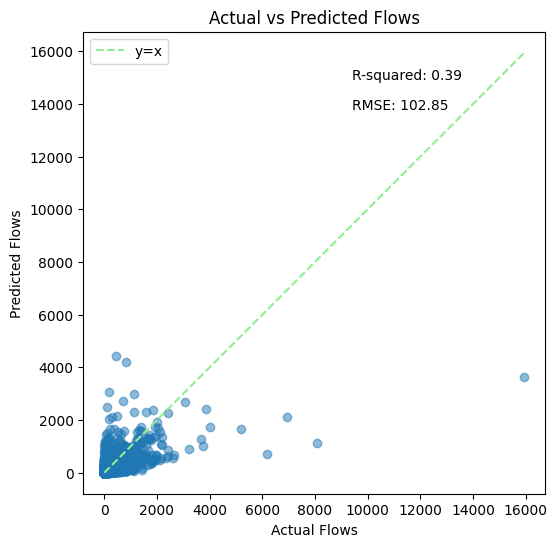

In [13]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(london_flows_pow['flows'], london_flows_pow['estimated_flows_pow'], alpha=0.5)
plt.title('Actual vs Predicted Flows')  # 设置图形标题
plt.xlabel('Actual Flows')  # 设置x轴标签
plt.ylabel('Predicted Flows')  # 设置y轴标签
plt.grid(True)  # 添加网格线以便于阅读
    
# 获取当前图形的坐标轴信息
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # 设置轴的比例相等

# 获取数据的最大值，以确定画线的范围
max_value = max(london_flows_pow['flows'].max(), london_flows_pow['estimated_flows_pow'].max())
    
# 绘制 y=x 的直线
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 显示图例
plt.legend()
# Display results on the plot
plt.figtext(0.55, 0.8, f'R-squared: {r_squared:.2f}')
plt.figtext(0.55, 0.75, f'RMSE: {rmse:.2f}')
plt.grid(False)
plt.show()
plt.show()  # 显示图形

In [14]:
london_flows_exp = london_flows.copy()
london_flows_exp, flow_est_exp = calculate_predictions_and_metrics(london_flows_exp, beta=beta2, gamma=gamma2,dist_method='exp',est_column_name="estimated_flows_exp")

flow_est_exp

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:38: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroup

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [15]:
from sklearn.metrics import r2_score, mean_squared_error
# Calculate R-squared
r_squared = r2_score(london_flows_exp['flows'], london_flows_exp['estimated_flows_exp'])
print("R-squared:", r_squared)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(london_flows_exp['flows'], london_flows_exp['estimated_flows_exp']))
print("RMSE:", rmse)

R-squared: 0.464020769437261
RMSE: 96.22382064334866


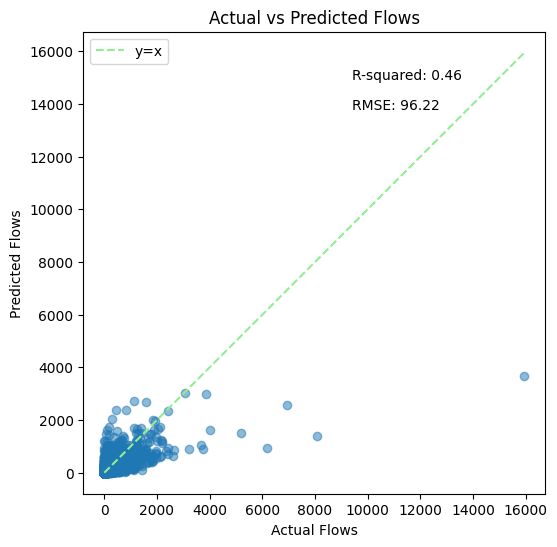

In [16]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(london_flows_exp['flows'], london_flows_exp['estimated_flows_exp'], alpha=0.5)
plt.title('Actual vs Predicted Flows')  # 设置图形标题
plt.xlabel('Actual Flows')  # 设置x轴标签
plt.ylabel('Predicted Flows')  # 设置y轴标签
plt.grid(True)  # 添加网格线以便于阅读
    
# 获取当前图形的坐标轴信息
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # 设置轴的比例相等

# 获取数据的最大值，以确定画线的范围
max_value = max(london_flows_exp['flows'].max(), london_flows_exp['estimated_flows_exp'].max())
    
# 绘制 y=x 的直线
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 显示图例
plt.legend()
# Display results on the plot
plt.figtext(0.55, 0.8, f'R-squared: {r_squared:.2f}')
plt.figtext(0.55, 0.75, f'RMSE: {rmse:.2f}')
plt.grid(False)
plt.show()
plt.show()  # 显示图形

## Scenario A

In [17]:
london_flows_ScenarioA = london_flows.copy()
london_flows_ScenarioA.loc[london_flows_ScenarioA['station_destination'] == 'Canary Wharf', 'jobs'] *= 0.5
london_flows_ScenarioA, flow_est_exp_ScenarioA = calculate_predictions_and_metrics(london_flows_ScenarioA, beta=beta2, gamma=gamma2,dist_method='exp',est_column_name="estimated_flows_ScenarioA")

flow_est_exp_ScenarioA

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:38: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroup

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


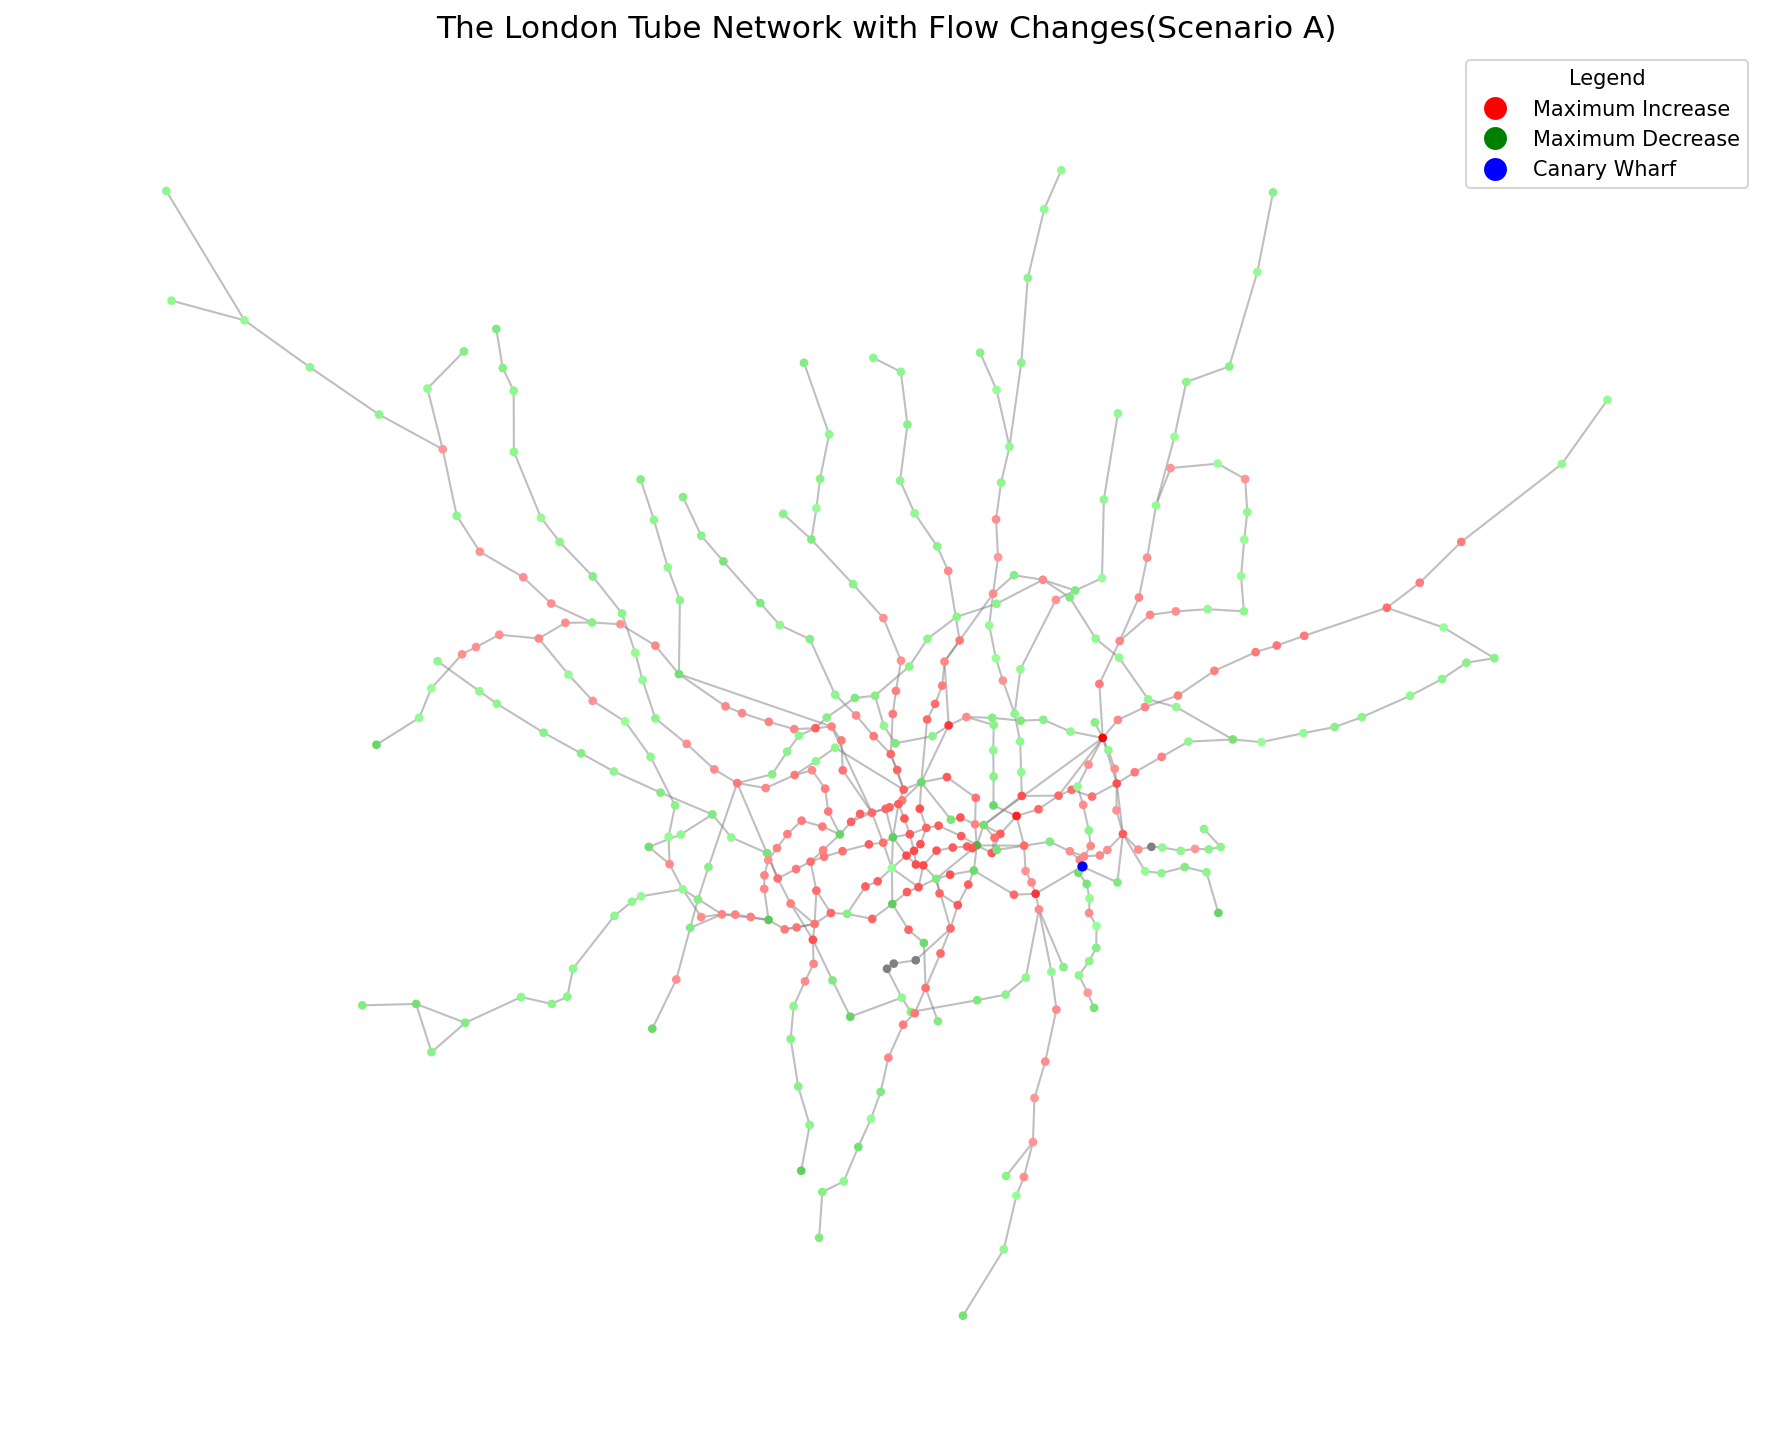

In [20]:
original_flows = OD_matrix.loc['All']
predicted_flows = flow_est_exp_ScenarioA.loc['All']
# 计算流量差异并创建颜色映射
flow_changes_ScenarioA = predicted_flows - original_flows
color_map_ScenarioA = {str(station): '#D993D9' if change > 0 else '#46CFE6' for station, change in flow_changes_ScenarioA.items()}

# 根据节点的坐标位置创建位置字典
pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes()}
# 计算流量变化百分比并为每个节点分配颜色
max_increase = np.max(flow_changes_ScenarioA)
max_decrease = np.min(flow_changes_ScenarioA)

# 创建色彩映射
# 更新色彩映射
increase_cmap = LinearSegmentedColormap.from_list("increase", ['#FF9999', '#FF0000'])  # 更鲜艳的红色渐变
decrease_cmap = LinearSegmentedColormap.from_list("decrease", ['#99FF99', '#008000'])  # 更鲜艳的绿色渐变


# 创建节点颜色映射
node_color_map = {}
for node, change in flow_changes_ScenarioA.items():
    if change > 0:
        # 使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(change / max_increase)
        node_color_map[node] = increase_cmap(color_intensity)
    elif change < 0:
        # 同样使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(abs(change) / abs(max_decrease))
        node_color_map[node] = decrease_cmap(color_intensity)
    else:
        node_color_map[node] = 'grey'

# 创建图形
fig, ax = plt.subplots(figsize=(15, 12), dpi=150)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=[node_color_map.get(node, 'grey') for node in G.nodes()], alpha=1)

# 特别突出显示Canary Wharf站点
canary_wharf = 'Canary Wharf'
if canary_wharf in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[canary_wharf], node_size=15, node_color='blue', node_shape='o')

# 创建图例
increase_patch = mlines.Line2D([], [], color=increase_cmap(1.0), marker='o', linestyle='None', markersize=10, label='Maximum Increase')
decrease_patch = mlines.Line2D([], [], color=decrease_cmap(1.0), marker='o', linestyle='None', markersize=10, label='Maximum Decrease')
canary_wharf_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Canary Wharf')

# 添加图例
legend_handles = [increase_patch, decrease_patch, canary_wharf_patch]

plt.legend(handles=legend_handles, loc='upper right', title="Legend")

# 关闭坐标轴
plt.axis("off")
# 设置图表的标题
plt.title('The London Tube Network with Flow Changes(Scenario A)', fontsize=15)
# 显示图形
plt.show()

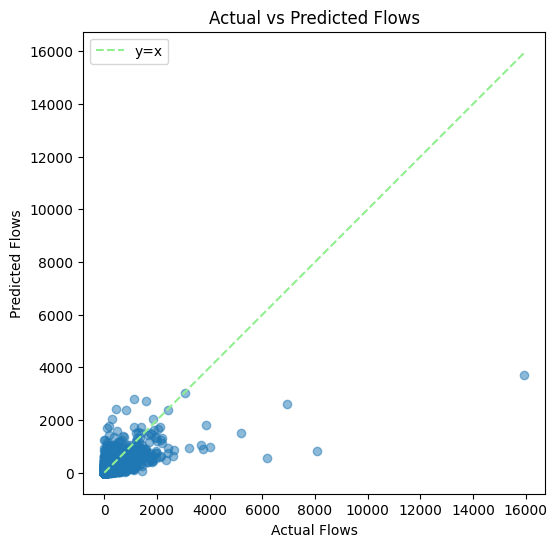

In [21]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(london_flows_ScenarioA['flows'], london_flows_ScenarioA['estimated_flows_ScenarioA'], alpha=0.5)
plt.title('Actual vs Predicted Flows')  # 设置图形标题
plt.xlabel('Actual Flows')  # 设置x轴标签
plt.ylabel('Predicted Flows')  # 设置y轴标签
plt.grid(True)  # 添加网格线以便于阅读
    
# 获取当前图形的坐标轴信息
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # 设置轴的比例相等

# 获取数据的最大值，以确定画线的范围
max_value = max(london_flows_ScenarioA['flows'].max(), london_flows_ScenarioA['estimated_flows_ScenarioA'].max())
    
# 绘制 y=x 的直线
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 显示图例
plt.legend()
plt.grid(False)
plt.show()  # 显示图形

In [22]:
london_flows_ScenarioB_1 = london_flows.copy()
london_flows_ScenarioB_1, flow_est_exp_ScenarioB_1 = calculate_predictions_and_metrics(london_flows_ScenarioB_1, beta=beta2*0.3, gamma=gamma2,dist_method='exp',est_column_name="estimated_flows_ScenarioB1")
flow_est_exp_ScenarioB_1

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:38: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroup

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,21.0,21.0,NaN,6.0,1.0,NaN,23.0,...,19.0,3.0,6.0,10.0,NaN,2.0,NaN,2.0,NaN,3745.0
Aldgate,NaN,NaN,4.0,NaN,24.0,NaN,NaN,0.0,NaN,22.0,...,9.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2884.0
Aldgate East,NaN,NaN,5.0,26.0,NaN,NaN,2.0,0.0,NaN,24.0,...,10.0,2.0,6.0,5.0,NaN,2.0,NaN,2.0,NaN,3177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,37.0,40.0,NaN,NaN,NaN,NaN,34.0,...,14.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4875.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,6.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


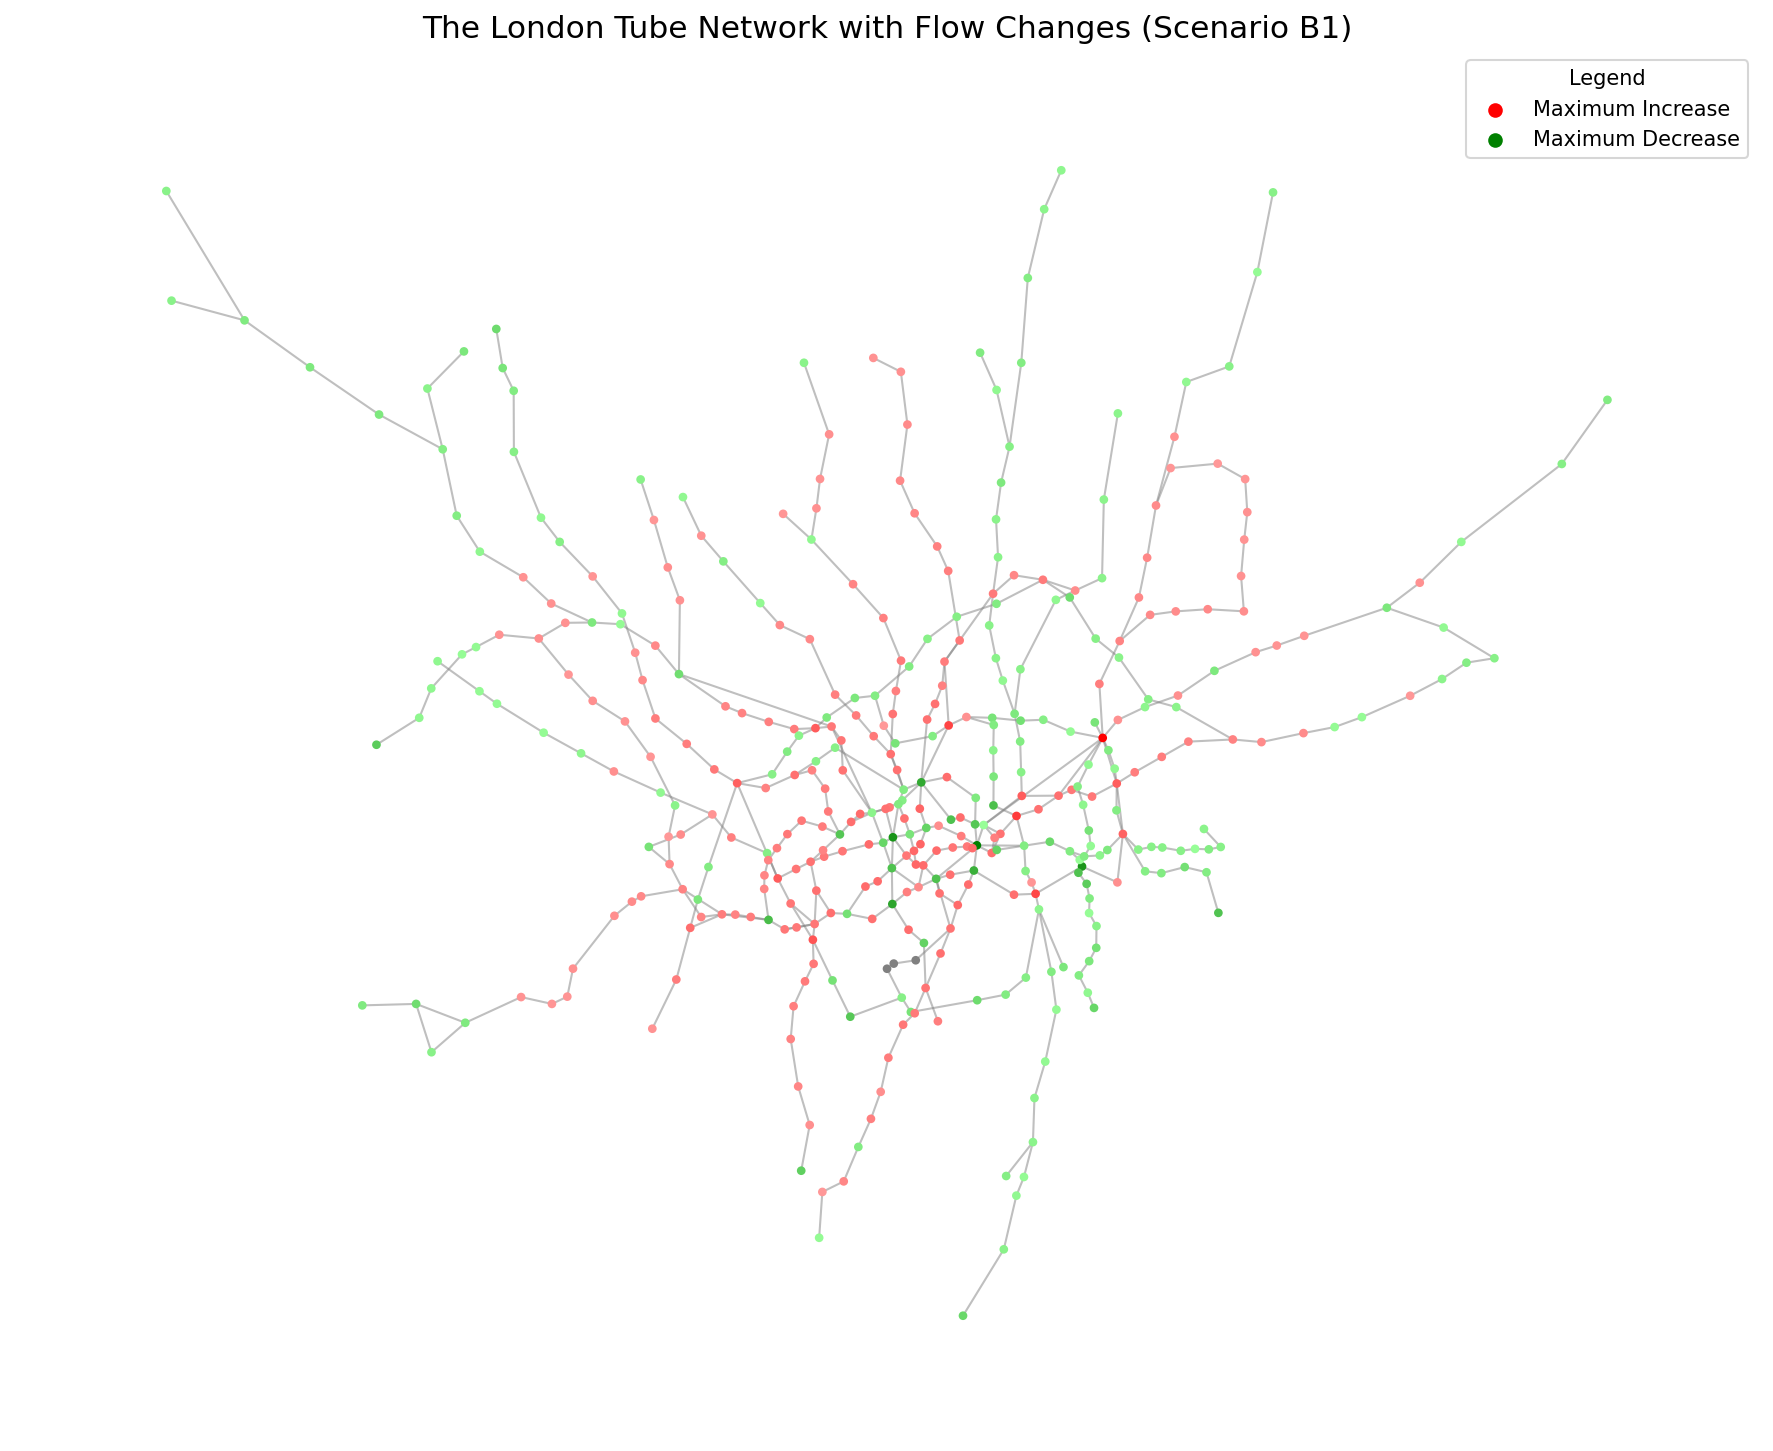

In [23]:
original_flows = OD_matrix.loc['All']
predicted_flows = flow_est_exp_ScenarioB_1.loc['All']
# 计算流量差异并创建颜色映射
flow_changes_ScenarioB_1 = predicted_flows - original_flows
#color_map_ScenarioB_1 = {str(station): '#D993D9' if change > 0 else '#46CFE6' for station, change in flow_changes_ScenarioB_1.items()}



# 计算流量变化百分比并为每个节点分配颜色
max_increase = np.max(flow_changes_ScenarioB_1)
max_decrease = np.min(flow_changes_ScenarioB_1)

# 创建色彩映射
# 更新色彩映射
increase_cmap = LinearSegmentedColormap.from_list("increase", ['#FF9999', '#FF0000'])  # 更鲜艳的红色渐变
decrease_cmap = LinearSegmentedColormap.from_list("decrease", ['#99FF99', '#008000'])  # 更鲜艳的绿色渐变


# 创建节点颜色映射
node_color_map = {}
for node, change in flow_changes_ScenarioB_1.items():
    if change > 0:
        # 使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(change / max_increase)
        node_color_map[node] = increase_cmap(color_intensity)
    elif change < 0:
        # 同样使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(abs(change) / abs(max_decrease))
        node_color_map[node] = decrease_cmap(color_intensity)
    else:
        node_color_map[node] = 'grey'

# 创建图形
fig, ax = plt.subplots(figsize=(15, 12), dpi=150)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=[node_color_map.get(node, 'grey') for node in G.nodes()], alpha=1)



# 添加图例
plt.scatter([], [], color=increase_cmap(1.0), label='Maximum Increase')
plt.scatter([], [], color=decrease_cmap(1.0), label='Maximum Decrease')
plt.legend(loc='upper right', title="Legend")

plt.axis("off")
plt.title('The London Tube Network with Flow Changes (Scenario B1)', fontsize=15)
plt.show()



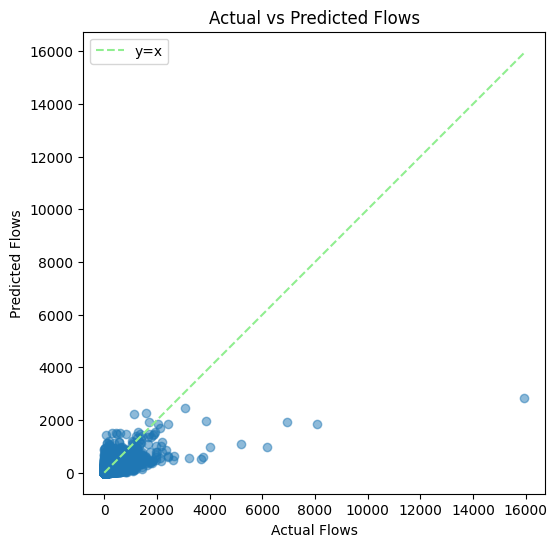

In [24]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(london_flows_ScenarioB_1['flows'], london_flows_ScenarioB_1['estimated_flows_ScenarioB1'], alpha=0.5)
plt.title('Actual vs Predicted Flows')  # 设置图形标题
plt.xlabel('Actual Flows')  # 设置x轴标签
plt.ylabel('Predicted Flows')  # 设置y轴标签
plt.grid(True)  # 添加网格线以便于阅读
    
# 获取当前图形的坐标轴信息
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # 设置轴的比例相等

# 获取数据的最大值，以确定画线的范围
max_value = max(london_flows_ScenarioB_1['flows'].max(), london_flows_ScenarioB_1['estimated_flows_ScenarioB1'].max())
    
# 绘制 y=x 的直线
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 显示图例
plt.legend()
plt.grid(False)
plt.show()  # 显示图形

In [25]:
london_flows_ScenarioB_2 = london_flows.copy()
london_flows_ScenarioB_2, flow_est_exp_ScenarioB_2 = calculate_predictions_and_metrics(london_flows_ScenarioB_2, beta=beta2*0.1, gamma=gamma2,dist_method='exp',est_column_name="estimated_flows_ScenarioB2")
flow_est_exp_ScenarioB_2

C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:38: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  Ai = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai"].agg(np.sum))
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  flow_log_est = london_flows.pivot_table(values=est_column_name, index="station_origin", columns="station_destination",
C:\Users\47692\AppData\Local\Temp\ipykernel_4196\3728000974.py:48: FutureWarning: The provided callable <function sum at 0x000001AC3EBFDDC0> is currently using DataFrameGroup

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,603.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,5.0,1.0,NaN,24.0,...,20.0,3.0,8.0,8.0,NaN,3.0,NaN,3.0,NaN,3741.0
Aldgate,NaN,NaN,6.0,NaN,20.0,NaN,NaN,1.0,NaN,20.0,...,13.0,NaN,6.0,5.0,NaN,3.0,NaN,3.0,NaN,2889.0
Aldgate East,NaN,NaN,7.0,22.0,NaN,NaN,3.0,1.0,NaN,21.0,...,14.0,2.0,7.0,5.0,NaN,3.0,NaN,3.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,33.0,35.0,NaN,NaN,NaN,NaN,33.0,...,22.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4864.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,7.0,21.0,21.0,NaN,3.0,NaN,NaN,23.0,...,15.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3088.0


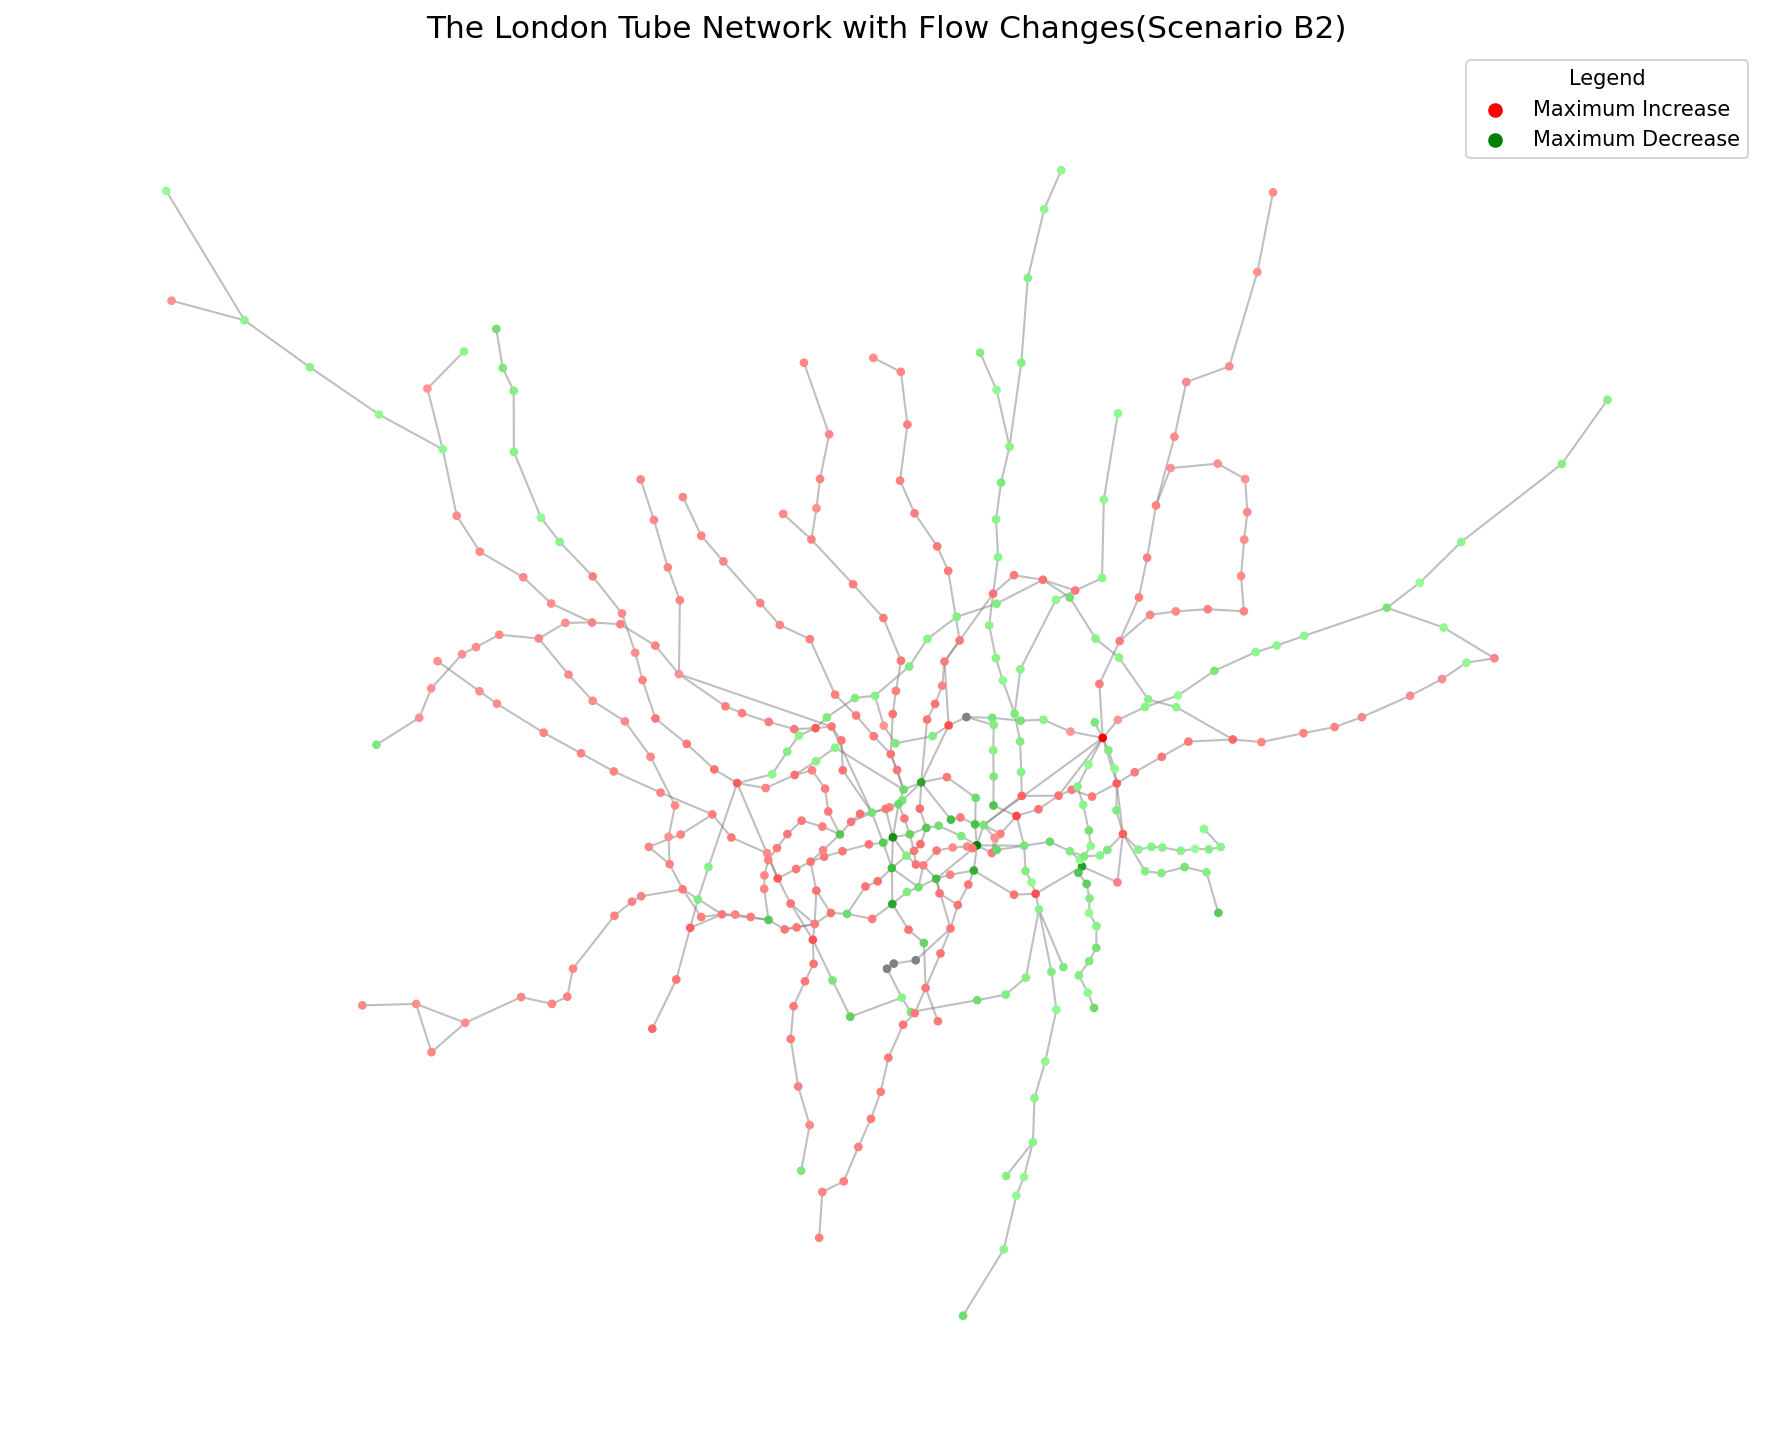

In [26]:

original_flows = OD_matrix.loc['All']
predicted_flows = flow_est_exp_ScenarioB_2.loc['All']
# 计算流量差异并创建颜色映射
flow_changes_ScenarioB_2 = predicted_flows - original_flows
#color_map_ScenarioB_2 = {str(station): '#D993D9' if change > 0 else '#46CFE6' for station, change in flow_changes_ScenarioB_2.items()}



# 计算流量变化百分比并为每个节点分配颜色
max_increase = np.max(flow_changes_ScenarioB_2)
max_decrease = np.min(flow_changes_ScenarioB_2)

# 创建色彩映射
# 更新色彩映射
increase_cmap = LinearSegmentedColormap.from_list("increase", ['#FF9999', '#FF0000'])  # 更鲜艳的红色渐变
decrease_cmap = LinearSegmentedColormap.from_list("decrease", ['#99FF99', '#008000'])  # 更鲜艳的绿色渐变


# 创建节点颜色映射
node_color_map = {}
for node, change in flow_changes_ScenarioB_2.items():
    if change > 0:
        # 使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(change / max_increase)
        node_color_map[node] = increase_cmap(color_intensity)
    elif change < 0:
        # 同样使用平方根函数增加小值的颜色变化
        color_intensity = np.sqrt(abs(change) / abs(max_decrease))
        node_color_map[node] = decrease_cmap(color_intensity)
    else:
        node_color_map[node] = 'grey'

# 创建图形
fig, ax = plt.subplots(figsize=(15, 12), dpi=150)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=[node_color_map.get(node, 'grey') for node in G.nodes()], alpha=1)



# 添加图例
plt.scatter([], [], color=increase_cmap(1.0), label='Maximum Increase')
plt.scatter([], [], color=decrease_cmap(1.0), label='Maximum Decrease')
plt.legend(loc='upper right', title="Legend")
# 关闭坐标轴
plt.axis("off")
# 设置图表的标题
plt.title('The London Tube Network with Flow Changes(Scenario B2)', fontsize=15)
# 显示图形
plt.show()

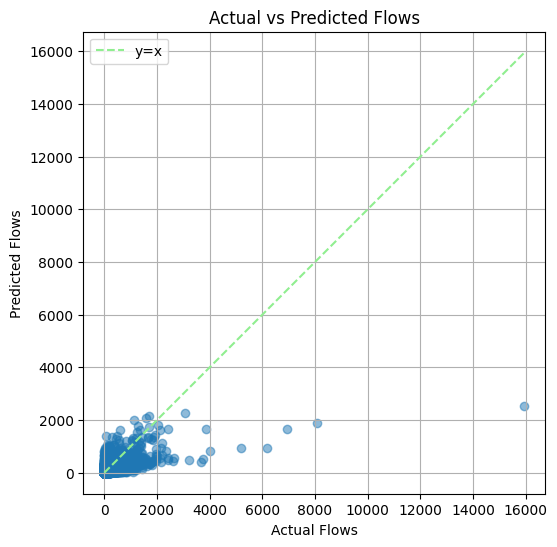

In [27]:
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(london_flows_ScenarioB_2['flows'], london_flows_ScenarioB_2['estimated_flows_ScenarioB2'], alpha=0.5)
plt.title('Actual vs Predicted Flows')  # 设置图形标题
plt.xlabel('Actual Flows')  # 设置x轴标签
plt.ylabel('Predicted Flows')  # 设置y轴标签
plt.grid(True)  # 添加网格线以便于阅读
    
# 获取当前图形的坐标轴信息
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')  # 设置轴的比例相等

# 获取数据的最大值，以确定画线的范围
max_value = max(london_flows_ScenarioB_2['flows'].max(), london_flows_ScenarioB_2['estimated_flows_ScenarioB2'].max())
    
# 绘制 y=x 的直线
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 显示图例
plt.legend()

plt.show()  # 显示图形

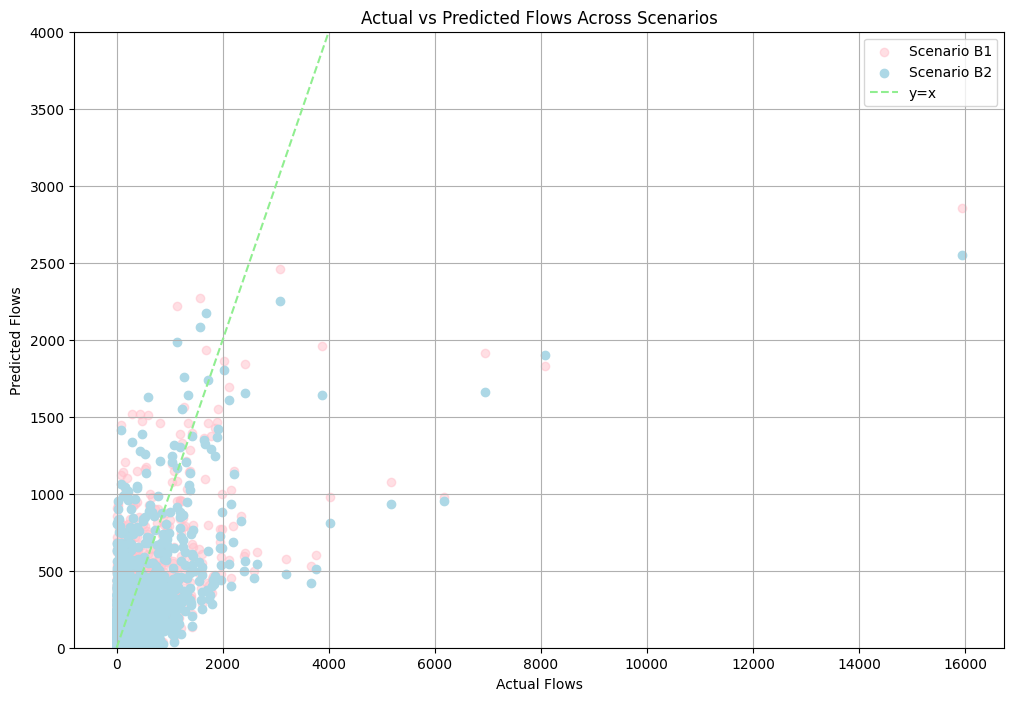

In [28]:
plt.figure(figsize=(12, 8))
plt.title('Actual vs Predicted Flows Across Scenarios')
plt.xlabel('Actual Flows')
plt.ylabel('Predicted Flows')
plt.grid(True)

# Scenario A
#plt.scatter(london_flows_ScenarioA['flows'], london_flows_ScenarioA['estimated_flows_ScenarioA'], 
#                color='lightblue', alpha=0.5, label='Scenario A')

# Scenario B1
plt.scatter(london_flows_ScenarioB_1['flows'], london_flows_ScenarioB_1['estimated_flows_ScenarioB1'], 
                color='pink', alpha=0.5, label='Scenario B1')

# Scenario B2
plt.scatter(london_flows_ScenarioB_2['flows'], london_flows_ScenarioB_2['estimated_flows_ScenarioB2'], 
                color='lightblue', alpha=1, label='Scenario B2')

# 绘制 y=x 的直线
max_value = max(
    #london_flows_ScenarioA['flows'].max(), london_flows_ScenarioA['estimated_flows_ScenarioA'].max(),
    london_flows_ScenarioB_1['flows'].max(), london_flows_ScenarioB_1['estimated_flows_ScenarioB1'].max(),
    london_flows_ScenarioB_2['flows'].max(), london_flows_ScenarioB_2['estimated_flows_ScenarioB2'].max()
)
plt.plot([0, max_value], [0, max_value], 'lightgreen', linestyle='--', label='y=x')

# 设置y轴的范围为0到4000
plt.ylim(0, 4000)

# 显示图例
plt.legend()

# 显示图形
plt.show()